# Your First Autoencoder

Version 1.31

(C) 2020 - Umberto Michelucci, Michela Sperti

This notebook is part of the book _Applied Deep Learning: a case based approach, **2nd edition**_ from APRESS by [U. Michelucci](mailto:umberto.michelucci@toelt.ai) and [M. Sperti](mailto:michela.sperti@toelt.ai).

The purpose of this notebook is to show you what an autoencoder is and what kind of tasks it can solve, through a real case example.

## Notebook Learning Goals

At the end of this notebook you will be able to build a simple autoencoder with Keras, using `Dense` layers in Keras and apply it to images, in particular to the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset and the [fashion MNIST](https://keras.io/api/datasets/fashion_mnist/) dataset as examples.

## Libraries Import

This section contains the necessary libraries (such as tensorflow or pandas) you need to import to run the notebook.

In [ ]:
# general libraries
import numpy as np
import pandas as pd
import time
import sys
import matplotlib.pyplot as plt

# tensorflow libraries
import tensorflow.keras as keras
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
import tensorflow as tf

# sklearn libraries
from sklearn import datasets 
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 
from sklearn.neighbors import KNeighborsClassifier 

Now we clone the repository for the book to be able to access the modules that we have written for all the jupyter notebooks.

In [ ]:
# Referring to the following cell, if you want to re-clone a repository
# inside the google colab instance, you need to delete it first. 
# You can delete the repositories contained in this instance executing 
# the following two lines of code (deleting the # comment symbol).

# !rm -rf ADL-Book-2nd-Ed 
# !rm -rf BCCD_Dataset

In [ ]:
# This command actually clone the repository of the book in the google colab
# instance. In this way this notebook will have access to the modules
# we have written for this book.

# Please note that in case you have already run this cell, and you run it again
# you may get the error message:
#
# fatal: destination path 'ADL-Book-2nd-Ed' already exists and is not an empty directory.
# 
# In this case you can safely ignore the error message.

!git clone https://github.com/toelt-llc/ADL-Book-2nd-Ed.git

fatal: destination path 'ADL-Book-2nd-Ed' already exists and is not an empty directory.


In [ ]:
# This cell imports some custom written functions that we have created to 
# make the plotting easier. You don't need 
# to undertsand the details and you can simply ignore this cell.
# Simply run it with CMD+Enter (on Mac) or CTRL+Enter (Windows or Ubuntu) to
# import the necessary functions.

import sys
sys.path.append('ADL-Book-2nd-Ed/modules/')

from plot_confusion_matrix import plot_cm

## MNIST and Fashion MNIST Datasets Import

For this notebook we will use two datasets:

- [MNIST Dataset](http://yann.lecun.com/exdb/mnist/)
- [Fashion MNIST @ Zalando](https://research.zalando.com/welcome/mission/research-projects/fashion-mnist/)

You can check the two datasets with the links above. They can be easily imported using Keras. Below you can see how easy is using [```tensorflow.keras.datasets```](https://www.tensorflow.org/api_docs/python/tf/keras/datasets).

In [ ]:
from keras.datasets import mnist

(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()

As usual we will do the typical normalisation of the datasets as you can see below. At this point in the book you should be able to understand the code below easily.

In [ ]:
mnist_x_train = mnist_x_train.astype('float32') / 255.
mnist_x_test = mnist_x_test.astype('float32') / 255.
mnist_x_train = mnist_x_train.reshape((len(mnist_x_train), np.prod(mnist_x_train.shape[1:])))
mnist_x_test = mnist_x_test.reshape((len(mnist_x_test), np.prod(mnist_x_test.shape[1:])))

In [ ]:
from keras.datasets import fashion_mnist

(fashion_x_train, fashion_y_train), (fashion_x_test, fashion_y_test) = fashion_mnist.load_data()

Note that we are doing the same normalisation for the fashion mnist datasets as for the classical MNIST.

In [ ]:
fashion_x_train = fashion_x_train.astype('float32') / 255.
fashion_x_test = fashion_x_test.astype('float32') / 255.
fashion_x_train = fashion_x_train.reshape((len(fashion_x_train), np.prod(fashion_x_train.shape[1:])))
fashion_x_test = fashion_x_test.reshape((len(fashion_x_test), np.prod(fashion_x_test.shape[1:])))

## Function to Create the Autoencoders

Now we need to create the ```keras``` models. An autoencoder is made of two main parts: an _encoder_ and a _decoder_. The function below ```create_autoencoders()``` returns the following parts as separate models:

- the encoder 
- the decoder
- the complete model, when the encoder and decoder are joined in one model.

In [ ]:
def create_autoencoders(feature_layer_dim = 16):

  input_img = Input(shape = (784,), name = 'Input_Layer')
  # 784 is the total number of pixels of MNIST images
  
  # The layer encoded has a dimension equal to feature_layer_dim and contains
  # the encoded input (therefore the name)
  encoded = Dense(feature_layer_dim, activation = 'relu', name = 'Encoded_Features')(input_img)
  decoded = Dense(784, activation = 'sigmoid', name = 'Decoded_Input')(encoded)

  autoencoder = Model(input_img, decoded)
  encoder = Model(input_img, encoded)

  encoded_input = Input(shape = (feature_layer_dim,))
  decoder = autoencoder.layers[-1]
  decoder = Model(encoded_input, decoder(encoded_input))

  return autoencoder, encoder, decoder

## Autoencoder with Layers with $(784,16,784)$ Neurons (MNIST Dataset)

As a first step let's create an autoencoder with the layer dimensions of $(784, 16, 784)$.




In [ ]:
# 16 is the number of latent features of our autoencoder
autoencoder, encoder, decoder = create_autoencoders(16) 

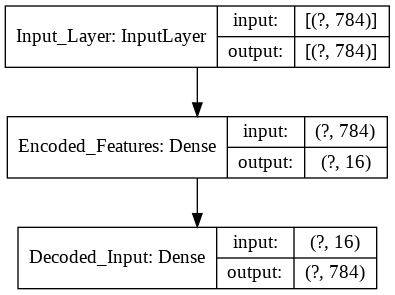

In [ ]:
keras.utils.plot_model(autoencoder, show_shapes = True)

As for any Keras model we need to compile the model and then fit it to the data. As you can see we don't need any custom code to work with autoencoders. A simple model **definition** $\rightarrow$ **compile** $\rightarrow$ **fit** is enough.

In [ ]:
autoencoder.compile(optimizer = 'adam', loss = 'binary_crossentropy')

In [ ]:
history = autoencoder.fit(mnist_x_train, mnist_x_train,
                          epochs = 30,
                          batch_size = 256,
                          shuffle = True,
                          validation_data = (mnist_x_test, mnist_x_test),
                          verbose = 0)

In [ ]:
encoded_imgs = encoder.predict(mnist_x_test)
decoded_imgs = decoder.predict(encoded_imgs)

### Some Notes about Compression

Since we have saved both the encoder and the decoder we can generate an encoded version of the images. Note that the data type of the images is ```float32```. Each ```float32``` require 4 bytes. The original data ```mnist_x_test``` has a shape of ```(10000,784)```. That means that the space needed to save this array is 

$$
10000 \textrm{ images} \times 784 \textrm{ pixels}\times 4 \textrm{ bytes} = 29 \textrm{ Mb}
$$

The encoded images require quite less space. Infact the size needed is

$$
10000 \textrm{ images}\times 16 \textrm{ latent features}\times 4 \textrm{ bytes} = 625 \textrm{ Kb}
$$

so if we accept the loss in quality in the compressed data we have achieved an incredible compression ratio of ca. $46$. It is easy to check those sizes by saving the data in a file and checking the file size. Note that the file size will be bigger, since there is some additional information that needs to be saved.

In [ ]:
np.save('temp_orig', mnist_x_test)
! ls -al temp_orig*

-rw-r--r-- 1 root root 31360128 Dec 17 14:59 temp_orig.npy


In [ ]:
np.save('temp_encoded', encoded_imgs)
! ls -al temp_encoded*

-rw-r--r-- 1 root root 640128 Dec 17 14:59 temp_encoded.npy


### Reconstructed Images Analysis

As noted above we have basically compressed our input images. But at what price? In the images below you can see what is the effect of having only 16 neurons in the middle layer.



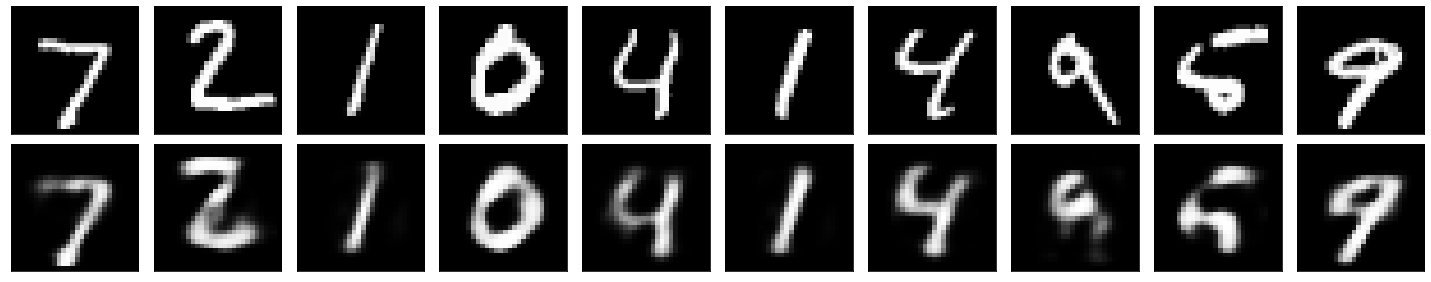

In [ ]:
n = 10  # how many digits we will display

fig = plt.figure(figsize = (20, 4))

for i in range(n):

    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(mnist_x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.tight_layout()
plt.show()

## Autoencoder with Layers with $(784,64,784)$ Neurons (MNIST Dataset)







In [ ]:
# now we use 64 latent features
autoencoder, encoder, decoder = create_autoencoders(64) 

In [ ]:
autoencoder.compile(optimizer = 'adam', loss = 'binary_crossentropy')

In [ ]:
autoencoder.fit(mnist_x_train, mnist_x_train,
                epochs = 30,
                batch_size = 256,
                shuffle = True,
                validation_data = (mnist_x_test, mnist_x_test),
                verbose = 0)

In [ ]:
encoded_imgs = encoder.predict(mnist_x_test)
decoded_imgs = decoder.predict(encoded_imgs)

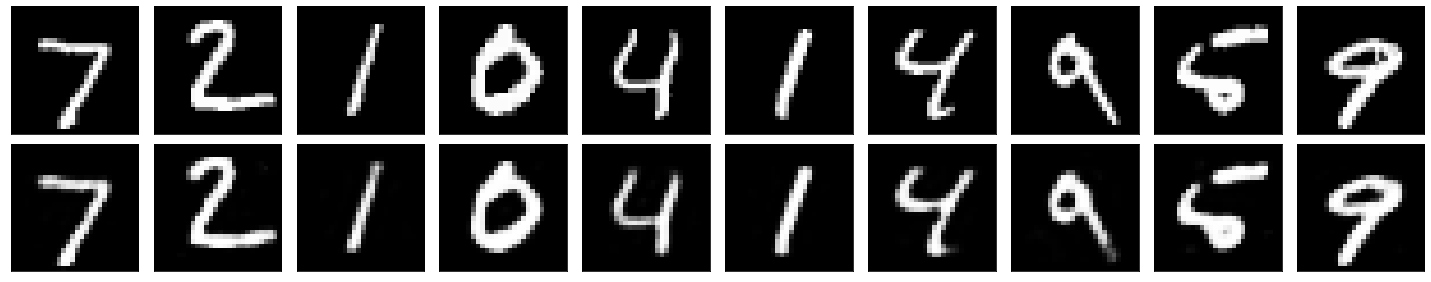

In [ ]:
n = 10  # how many digits we will display

fig = plt.figure(figsize=(20, 4))

for i in range(n):

    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(mnist_x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.tight_layout()
plt.show()

## Autoencoder with Layers with $(784,8,784)$ Neurons (MNIST Dataset)

We can check how, reducing the number of neurons in the middle layer, the quality of the reconstruction drops since the dimensionality reduction is too extreme in this case.

In [ ]:
# in this final example, we use only 8 latent features
autoencoder, encoder, decoder = create_autoencoders(8) 
autoencoder.compile(optimizer = 'adam', loss = 'binary_crossentropy')
autoencoder.fit(mnist_x_train, mnist_x_train,
                epochs = 30,
                batch_size = 256,
                shuffle = True,
                validation_data = (mnist_x_test, mnist_x_test),
                verbose = 0)

In [ ]:
encoded_imgs = encoder.predict(mnist_x_test)
decoded_imgs = decoder.predict(encoded_imgs)

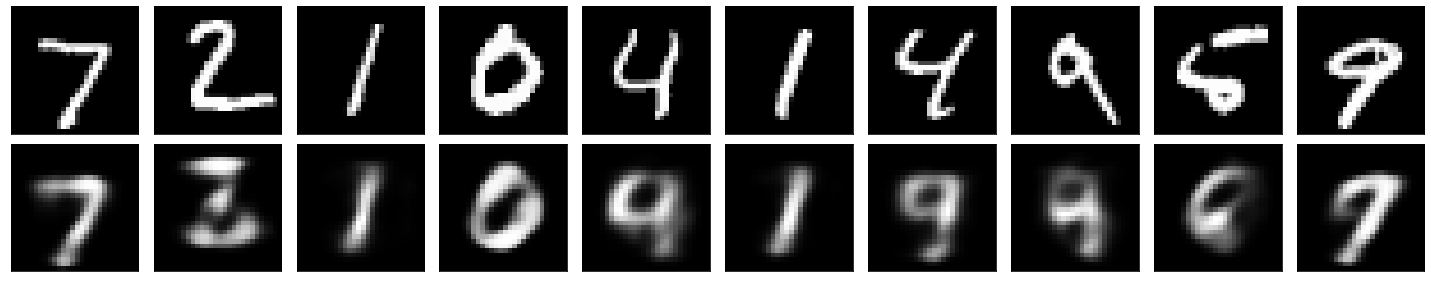

In [ ]:
n = 10  # how many digits we will display

fig = plt.figure(figsize=(20, 4))

for i in range(n):

    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(mnist_x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.tight_layout()
plt.show()

#fig.savefig('comparison_8.png')

## Classification with the Latent Features (MNIST Dataset)
Now let's check how we can use the latent features, or in other words the output of the middle layer, to do some classification. Are we loosing much accuracy? What about performance of the algorithms? Let's check some examples.

### KNN Study

The first algorithm that we can test is KNN. To do it we can simply use ```sklearn```.

In [ ]:
encoded_train_imgs = encoder.predict(mnist_x_train)
# decoded_imgs = decoder.predict(encoded_imgs)

Note how the variable ```encoded_train_imgs``` has only 8 features (remember the last autoencoders we trained had only 8 neurons in the middle layer). The original dataset had 784 features (the pixel gray values of the images).

In [ ]:
encoded_train_imgs.shape

(60000, 8)

We will now train the classifier with the encoded images and we will measure how long it takes for the training. Later we will do the same with the original dataset and compare results and running time.

In [ ]:
start = time.time()
 
# training a KNN classifier 
knn = KNeighborsClassifier(n_neighbors = 7).fit(encoded_train_imgs, mnist_y_train) 
  
# accuracy on X_test 
accuracy = knn.score(encoded_imgs, mnist_y_test) 
print('The accuracy on the test set is: ', accuracy)

end = time.time()

print('Running time', end - start, 'sec.') 

The accuracy on the test set is:  0.8967
Running time 1.2429447174072266 sec.


With just the 8 features we get an incredible 90% of accuracy in 1.2 sec. 

In [ ]:
# The following line contains the class with the method that enables confusion matrix plotting.
pcm = plot_cm()

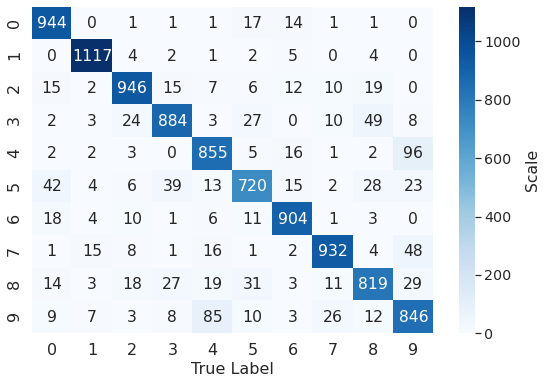

In [ ]:
# creating a confusion matrix 
knn_predictions = knn.predict(encoded_imgs)  
cm = confusion_matrix(mnist_y_test, knn_predictions)
pcm.plot_confmat(cm, [0,1,2,3,4,5,6,7,8,9], 'confusion_matrix.png')

### KNN with All the Features

Now let's train a classifier with all 784 features.

In [ ]:
start = time.time()

knn2 = KNeighborsClassifier(n_neighbors = 7).fit(mnist_x_train, mnist_y_train)

# accuracy on X_test 
accuracy = knn2.score(mnist_x_test, mnist_y_test)  
print('The accuracy on the test set is: ', accuracy)

end = time.time()

print('Running time', end - start, 'sec.') 

The accuracy on the test set is:  0.9694
Running time 843.27956199646 sec.


With all the features we get 97% accuracy (7% more than with just 8 features) but it takes 1000 times longer, around 16 minutes. If instead of 10000 observations we had few millions, this 1000 time gain will become not only significant but it may mean the difference between training a model or not being able to.

## MSE (MNIST Dataset)

Autoencoders are so flexible that they work even if we use as loss function the MSE. We can try it quickly in the example below. More details about the loss functions are discussed in the book.

In [ ]:
dim = 16

input_img = Input(shape = (784,))
encoded = Dense(dim, activation = 'relu')(input_img)
decoded = Dense(784, activation = 'sigmoid')(encoded)

autoencoder = Model(input_img, decoded)
encoder = Model(input_img, encoded)

In [ ]:
encoded_input = Input(shape = (dim,))
decoder = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder(encoded_input))

In [ ]:
autoencoder.compile(optimizer = 'adam', loss = 'mse')

In [ ]:
autoencoder.fit(mnist_x_train, mnist_x_train,
                epochs = 30,
                batch_size = 256,
                shuffle = True,
                validation_data = (mnist_x_test, mnist_x_test),
                verbose = 0)

In [ ]:
encoded_imgs = encoder.predict(mnist_x_test)
decoded_imgs = decoder.predict(encoded_imgs)

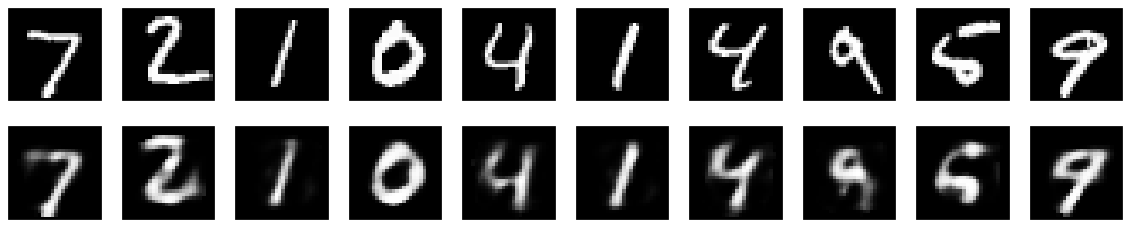

In [ ]:
n = 10  # how many digits we will display

fig = plt.figure(figsize=(20, 4))

for i in range(n):

    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(mnist_x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

#fig.savefig('comparison_MSE_16.png')

## Fashion MNIST

We can use an autoencoder with the FASHION MNIST dataset now. We will just try to build one with 8 neurons in the middle layer.

In [ ]:
autoencoder, encoder, decoder = create_autoencoders(8)
autoencoder.compile(optimizer = 'adam', loss = 'binary_crossentropy')
autoencoder.fit(fashion_x_train, fashion_x_train,
                epochs = 30,
                batch_size = 256,
                shuffle = True,
                validation_data = (fashion_x_test, fashion_x_test),
                verbose = 1)

Epoch 1/30
235/235 [==============================] - 2s 10ms/step - loss: 0.4638 - val_loss: 0.3881
Epoch 2/30
235/235 [==============================] - 2s 8ms/step - loss: 0.3645 - val_loss: 0.3517
Epoch 3/30
235/235 [==============================] - 2s 8ms/step - loss: 0.3428 - val_loss: 0.3388
Epoch 4/30
235/235 [==============================] - 2s 8ms/step - loss: 0.3332 - val_loss: 0.3320
Epoch 5/30
235/235 [==============================] - 2s 8ms/step - loss: 0.3279 - val_loss: 0.3279
Epoch 6/30
235/235 [==============================] - 2s 8ms/step - loss: 0.3244 - val_loss: 0.3251
Epoch 7/30
235/235 [==============================] - 2s 8ms/step - loss: 0.3217 - val_loss: 0.3227
Epoch 8/30
235/235 [==============================] - 2s 8ms/step - loss: 0.3196 - val_loss: 0.3209
Epoch 9/30
235/235 [==============================] - 2s 8ms/step - loss: 0.3180 - val_loss: 0.3194
Epoch 10/30
235/235 [==============================] - 2s 8ms/step - loss: 0.3168 - val_loss: 0.318

In [ ]:
encoded_imgs = encoder.predict(fashion_x_test)
decoded_imgs = decoder.predict(encoded_imgs)

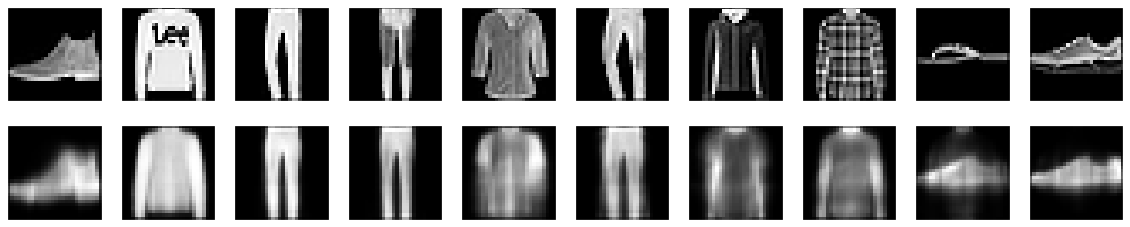

In [ ]:
n = 10  # how many digits we will display

plt.figure(figsize = (20, 4))

for i in range(n):

    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(fashion_x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

And again we can try to build a classifier with all the data. Also in this case, as it would be expected, it take almost 16 minutes. Quite a long time.

In [ ]:
start = time.time()

knn = KNeighborsClassifier(n_neighbors = 7).fit(fashion_x_train, fashion_y_train) 

# accuracy on X_test 
accuracy = knn.score(fashion_x_test, fashion_y_test) 
print('The accuracy on the test set is: ', accuracy)

end = time.time()

print('Running time', end - start, 'sec.') 

The accuracy on the test set is:  0.854
Running time 892.2216928005219 sec.


### KNN on Learned Representation

In [ ]:
encoded_fashion_train_imgs = encoder.predict(fashion_x_train)
encoded_fashion_test_imgs = encoder.predict(fashion_x_test)

In [ ]:
start = time.time()
 
# training a KNN classifier 
knn = KNeighborsClassifier(n_neighbors = 7).fit(encoded_fashion_train_imgs, fashion_y_train) 
  
# accuracy on X_test 
accuracy = knn.score(encoded_fashion_test_imgs, fashion_y_test) 
print('The accuracy on the test set is: ', accuracy)

end = time.time()
print('Running time', end - start, 'sec.') 

The accuracy on the test set is:  0.7997
Running time 0.8577823638916016 sec.


So again we loose ca. 5% of accuracy but we are 1000 times faster. Quite impressive. 

### KNN Accuracy with an Autoencoder with Number of Neurons in the Layers $(784,16,784)$

In [ ]:
autoencoder, encoder, decoder = create_autoencoders (16)
autoencoder.compile(optimizer = 'adam', loss = 'binary_crossentropy')
autoencoder.fit(fashion_x_train, fashion_x_train,
                epochs = 30,
                batch_size = 256,
                shuffle = True,
                validation_data = (fashion_x_test, fashion_x_test),
                verbose = 0)

In [ ]:
encoded_fashion_train_imgs = encoder.predict(fashion_x_train)
encoded_fashion_test_imgs = encoder.predict(fashion_x_test)

In [ ]:
start = time.time()
 
# training a KNN classifier 
knn = KNeighborsClassifier(n_neighbors = 7).fit(encoded_fashion_train_imgs, fashion_y_train) 
  
# accuracy on X_test 
accuracy = knn.score(encoded_fashion_test_imgs, fashion_y_test) 
print('The accuracy on the test set is: ', accuracy)

end = time.time()
print('Running time', end - start, 'sec.') 

The accuracy on the test set is:  0.8375
Running time 2.9405202865600586 sec.


Now increasing the number of neurons in the middle layer to 16 will give us an accuracy equal to 84% in 3 seconds. A minor increase in running time that is well worth! Still doing the same classification with all the features would require 1000 sec.

## Exercises

1. [*Easy Difficulty*] Try to build yourself three different autoencoders with the following layers: $(784,64,784)$, $(784,16,784)$ and $(784,8,784)$ and apply them to the FASHION MNIST dataset. Then, plot together the original version of the images and the encoded ones. See how results change in each case and decide which is the best trade-off between images' resolution and size.
2. [*Medium Difficulty*] Try the same autoencoders you developed in Exercise 1, adding one hidden layer of 300 units inside the encoder and another identical one inside the decoder. See how plots change, always comparing results with the original images.
3. [*Medium Difficulty*] Try the notebook on another online dataset, for example this: https://www.kaggle.com/andrewmvd/animal-faces (containing 16130 high-quality images of cats, dogs and wildlife animals at 512×512 resolution).
4. [*Hard Difficulty*] Using the autoencoder you developed in Exercise 2 (the one with two hidden layers) try to visualize the features learned by the autoencoder itself, in the following way: for each neuron in the first hidden layer create an image where a pixel's intensity corresponds to the weight of the connection to the neuron itself.